<a href="https://colab.research.google.com/github/mok33/GMEs_experiments/blob/master/GEMs_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## sampling TGEMs

![alt text](https://i.imgur.com/Q6qUYlf.png)

On suppose que les evenements ont lieu dans l'interval W = [0, 100]

In [0]:
W_min, W_max = 0, 100
win_len = W_max - W_min

### (A)

### description du model 

$
nodes = A \\
edges = \emptyset \\
timescales = \emptyset \\
\lambda_{A}(t \mid h) = 1/10 \\
$


In [0]:
lambda_A = 1/10

lambda_A (rate function) est constant, le noeud A n'a pas de parent, ceci revient donc à échentillonner (?) un processus de Poisson homogene.

### Sampling

In [0]:
#étape 1: nombre de réalistion de l'évenement A attendu est:
espA = lambda_A * (win_len)
#étape 2: placement des aléatoire des points de A 
A_t = np.random.uniform(low=W_min, high=W_max, size=int(espA))
#tri
A_t = np.sort(A_t)

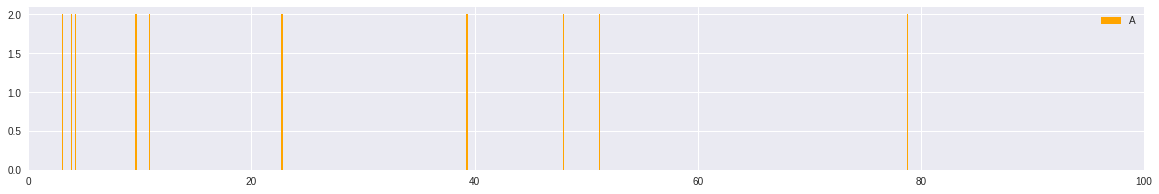

In [464]:
plt.figure(num=None, figsize=(20, 3))
plt.bar(A_t, height=2, width=.1, color='orange')
plt.legend('A')
plt.xlim(0,100)
plt.show()

### Calcul de vraisemblence

In [0]:
def get_count_duration_df(data, lambda_col='lambda_t', time_col='index'):
    lambda_vals = data[lambda_col].unique()
    lambda_count_duration_df = pd.DataFrame(data={'lambda_l_t': lambda_vals,\
                                              'count': [0] * len(lambda_vals),\
                                              'duration': [0] * len(lambda_vals)
                                             }
                                       )
    lambda_count_duration_df['duration'] = lambda_count_duration_df['lambda_l_t'].apply(lambda lm: (((data[lambda_col] == lm) * 1.0) * (data[time_col] - data[time_col].shift().fillna(0))).sum())
    lambda_count_duration_df['count'] = lambda_count_duration_df['lambda_l_t'].apply(lambda lm: (data[lambda_col] == lm).sum())
    
    return lambda_count_duration_df

In [0]:
def compute_likelihood(count_duration_df, duration_as_time=True):
    if duration_as_time:
      count_duration_df['duration'] = count_duration_df['duration'].dt.total_seconds()
    return ((count_duration_df['lambda_l_t'] ** count_duration_df['count']) * 
            np.exp(-count_duration_df['lambda_l_t'] * count_duration_df['duration'])).prod()

In [0]:
samplde_data_model_A = pd.DataFrame(data={'time': A_t, 'lambda_A_t': [lambda_A] * len(A_t)})

In [0]:
model_A_count_drt_df = get_count_duration_df(samplde_data_model_A, 'lambda_A_t', 'time')

In [422]:
model_A_count_drt_df

,count,duration,lambda_l_t
0,10,93.635142,0.1


In [437]:
A_t[-1] - 0 #(duration)

93.63514197964356

$
\begin{align}
p(x_{t^{*}} \mid t^{*}) = \prod_{l \in \mathcal{L}} \prod_{j \in \mathcal{C_{l}}} \
\lambda_{l,j}^{n_{t^{*}, l, j}(x_{t^{*}})}e^{-\lambda_{l,j}d_{t^{*},l,j}(x_{t^{*}})}
\end{align}
$

In [0]:
#likelihood, model 1 y u do dis to me :( fffffffffffffffffffffuuuuuuuuuuuuuuuu
compute_likelihood(model_A_count_drt_df)*

### (A) -> (B)

$
nodes = A, B \\
edges = (A, B) \\
timescales = T_{A \rightarrow B} = {(0,5],(5, 20]} \\
\lambda_{A}(t \mid h) = 2.5 \\
\lambda_{B \mid 00}(t \mid h) = 0.003 \\
\lambda_{B \mid 01}(t \mid h) = 5 \\
\lambda_{B \mid 10}(t \mid h) = 2 \\
\lambda_{B \mid 11}(t \mid h) = 5 \\
$

In [0]:
lambda_A = 2.5
lambda_B = {
            (0,0): 0.003, \
            (0,1): 1.6, \
            (1,0): 3, \
            (1,1) : 1
            }
timescales_parent_B = [[0,5], [5, 20]]

### Sampling

In [0]:
#on commence par A

In [0]:
#étape 1: nombre de réalistion de l'évenement A attendu est:
espA = lambda_A * (win_len)
#étape 2: placement des aléatoire des points de A 
A_t = np.random.uniform(low=W_min, high=W_max, size=int(espA))
#tri
A_t = np.sort(A_t)

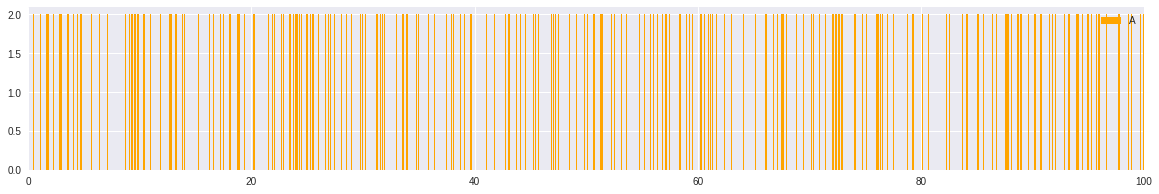

In [472]:
plt.figure(num=None, figsize=(20, 3))
plt.bar(A_t, height=2, width=0.1, color='orange')
plt.legend('A')
plt.xlim(0,100)
plt.show()

In [0]:
def get_parent_count_vector(t, parent_time_serie, timescales):
    count_vect = np.repeat(repeats=len(timescales), a=0)
    for i, (a, b) in enumerate(timescales):
        count_vect[i] = ((parent_time_serie >= t - b) & (parent_time_serie < t - a)).sum()
    count_vect = (count_vect >= 1) * 1
    return tuple(count_vect)

In [0]:
lambda_b_t = [(t,lambda_B[get_parent_count_vector(t, A_t, timescales_parent_B)]) for t in np.append(np.array([W_min]), A_t)]
lambda_b_t_df = pd.DataFrame(data=lambda_b_t).rename(columns={0: 'time', 1: 'lambda_t'})

In [0]:
lambda_b_t_df['time_range'] = (lambda_b_t_df != lambda_b_t_df.shift(1))['lambda_t'].cumsum()
lambda_b_t_df = lambda_b_t_df.groupby(['lambda_t', 'time_range'])['time'].agg(['min'])['min'].reset_index().sort_values('min')

In [0]:
lambda_b_t_df['time_change'] = lambda_b_t_df['min'].shift(-1).fillna(W_max)

In [477]:
lambda_b_t_df

,lambda_t,time_range,min,time_change
0,0.003,1,0.000000,1.068477
2,3.000,2,1.068477,5.707514
1,1.000,3,5.707514,100.000000


In [0]:
t = W_min
B_t = np.array([])
lambda_b_t = np.array([])

row_n = 0

while t < W_max:
    t_lambda_change = lambda_b_t_df.iloc[row_n]['time_change']
    lambda_B_t = lambda_b_t_df.iloc[row_n]['lambda_t']
    
    y = np.random.uniform()
    waiting_time = -np.log(1-y) / lambda_B_t
    
    if t + waiting_time < t_lambda_change: 
        t += waiting_time
        B_t = np.append(B_t, t)
        lambda_b_t = np.append(lambda_b_t, lambda_B_t)
    else:
        t = t_lambda_change
        row_n += 1

In [0]:
A_t = pd.to_timedelta(A_t, unit='s')
B_t = pd.to_timedelta(B_t, unit='s')

time = A_t.append(B_t)
sampled_data = pd.DataFrame(index=time, data={'event': ['B'] * len(time)})
sampled_data.loc[A_t] = 'A'
sampled_data.sort_index(inplace=True)

In [480]:
sampled_data

,event
00:00:00.487732,A
00:00:01.068477,A
00:00:01.448578,B
00:00:01.622503,A
00:00:01.759334,A
00:00:01.767516,B
00:00:01.774908,A
00:00:01.923477,B
00:00:02.119441,B
00:00:02.234684,A


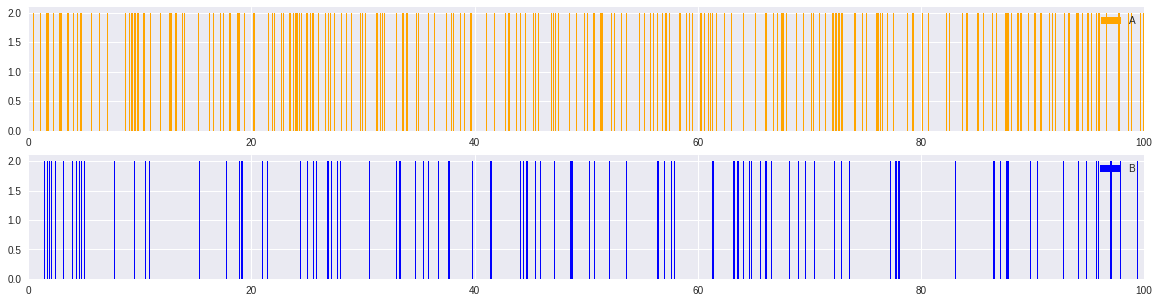

In [483]:
plt.figure(num=None, figsize=(20, 5))

plt.subplot(2, 1, 1)
plt.bar(A_t.total_seconds(), height=2, width=0.1, color='orange')
plt.legend('A')
plt.xlim(0,100)

plt.subplot(2, 1, 2)
plt.bar(B_t.total_seconds(), height=2, width=0.1, color='blue')
plt.legend('B')
plt.xlim(0,100)

plt.show()

## calcul de vraisemblence

$
\begin{align}
p(x_{t^{*}} \mid t^{*}) = \prod_{l \in \mathcal{L}} \prod_{j \in \mathcal{C_{l}}} \
\lambda_{l,j}^{n_{t^{*}, l, j}(x_{t^{*}})}e^{-\lambda_{l,j}d_{t^{*},l,j}(x_{t^{*}})}
\end{align}
$

In [0]:
sampled_data['lambda_t'] = lambda_A
sampled_data.loc[sampled_data['event'] == 'B', 'lambda_t'] = lambda_b_t
sampled_data.reset_index(inplace=True)

In [485]:
%time lambda_count_duration_df = get_count_duration_df(sampled_data)

CPU times: user 15.4 ms, sys: 1.06 ms, total: 16.4 ms
Wall time: 18.9 ms


In [486]:
lambda_count_duration_df

,count,duration,lambda_l_t
0,250,00:01:16.342947,2.5
1,11,00:00:02.183618,3.0
2,90,00:00:21.446740,1.0


In [487]:
#likelihood, model 2 y u do dis to me :( fffffffffffffffffffffuuuuuuuuuuuuuuuu
compute_likelihood(lambda_count_duration_df)

4851016683.48349

## (A) - > (B) -> (A)

$
\begin{align}
nodes: A, B \\
edges: (A, B), (B, A) \\
timescales: T_{A \rightarrow B} = {(0,5],(6, 13], (30,45]}, T_{B \rightarrow A} = {(0,3],(5, 13]}\\
\lambda_{A \mid 00}(t \mid h) = 2.5 \\
\lambda_{A \mid 01}(t \mid h) = 4 \\
\lambda_{A \mid 11}(t \mid h) = 0.1 \\
\lambda_{A \mid 10}(t \mid h) = 0.01 \\
\lambda_{B \mid 000}(t \mid h) = 0.3 \\
\lambda_{B \mid 001}(t \mid h) = 5 \\
\lambda_{B \mid 010}(t \mid h) = 3 \\
\lambda_{B \mid 100}(t \mid h) = 1.1 \\
\lambda_{B \mid 011}(t \mid h) = 4.3 \\
\lambda_{B \mid 110}(t \mid h) = 3 \\
\lambda_{B \mid 101}(t \mid h) = 1 \\
\lambda_{B \mid 111}(t \mid h) = 2 \\
\end{align}
$

In [0]:
T_A_pa = [[0,3], [5,6]]
T_B_pa = [[0,0.5], [4,4.8], [20,2.7]]

In [0]:
lambda_A = {
            (0,0): 2.5, \
            (0,1): 4, \
            (1,0): 0.01, \
            (1,1) : 0.1
            }
lambda_B = {
            (0,0,0): 1/6, \
            (0,0,1): 2/6, \
            (0,1,0): 4/6, \
            (1,0,0) : 1, \
            (0,1,1): 1/2, \
            (1,1,0): 2/3, \
            (1,0,1): 3/6, \
            (1,1,1): 1
            }

In [0]:
t_until_change_lambda_A = np.random.uniform(W_max, size=np.random.randint(len(lambda_A) * 2) + 1)
t_until_change_lambda_A = (np.cumsum(t_until_change_lambda_A) / np.sum(t_until_change_lambda_A)) * 100

In [0]:
t_until_change_lambda_B = np.random.uniform(W_max, size=np.random.randint(len(lambda_B) * 2) + 1)
t_until_change_lambda_B = (np.cumsum(t_until_change_lambda_B) / np.sum(t_until_change_lambda_B)) * 100

In [0]:
time_serie = {
              'A_t':  np.array([]), \
              'B_t': np.array([])
             }
t = W_min
lambda_t = np.array([])
while t < W_max:
    pcv_A = get_parent_count_vector(t, time_serie['A_t'], T_A_pa)
    pcv_B = get_parent_count_vector(t, time_serie['B_t'], T_B_pa)
    
    lambda_t_i = [lambda_A[pcv_A], lambda_B[pcv_B]]
    
    Y = np.random.uniform(size=2)
    taus = -np.log(1-Y) / lambda_t_i
    
    lambda_unchanged_t = (t_until_change_lambda_A[t_until_change_lambda_A >= t][0], \
                         t_until_change_lambda_B[t_until_change_lambda_B >= t][0])
    
    min_tau_i = taus.argmin()
    if t + taus[min_tau_i] < lambda_unchanged_t[min_tau_i]:
        lambda_t = np.append(lambda_t, lambda_t_i[min_tau_i])
        t += taus[min_tau_i]
        
        event_name = list(time_serie.keys())[min_tau_i]
        time_serie[event_name] = np.append(time_serie[event_name], t)
    else:
        t = lambda_unchanged_t[min_tau_i]

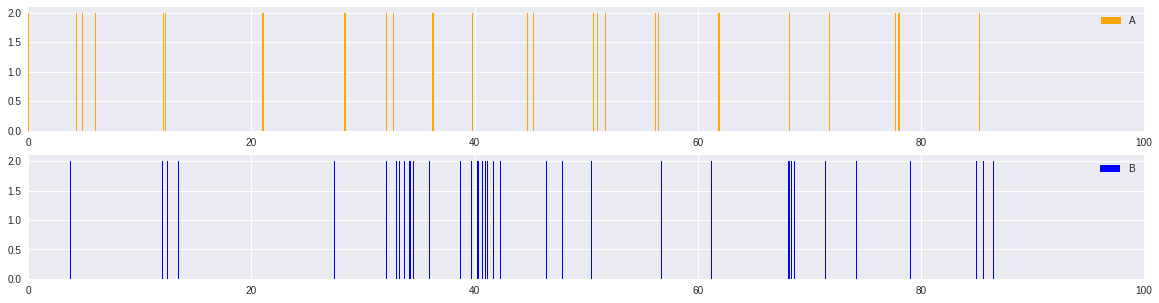

In [495]:
plt.figure(num=None, figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.bar(time_serie['A_t'], height=2, width=0.1, color='orange')
plt.legend('A')
plt.xlim(0,100)

plt.subplot(2, 1, 2)
plt.bar(time_serie['B_t'], height=2, width=0.1, color='blue')
plt.legend('B')
plt.xlim(0,100)

plt.show()

In [0]:
sampled_data_model_cycle = pd.DataFrame(index=np.append(time_serie['A_t'], time_serie['B_t']))

In [0]:
sampled_data_model_cycle.loc[time_serie['A_t'], 'event'] = 'A'
sampled_data_model_cycle.loc[time_serie['B_t'], 'event'] = 'B'

In [0]:
sampled_data_model_cycle.sort_index(inplace=True)

In [0]:
sampled_data_model_cycle['lambda_t'] = lambda_t

In [500]:
sampled_data_model_cycle

,event,lambda_t
0.042708,A,2.500000
0.062664,A,2.500000
3.790887,B,0.166667
4.357622,A,2.500000
4.855193,A,2.500000
6.063530,A,0.010000
12.070523,B,0.166667
12.088941,A,2.500000
12.294050,A,2.500000
12.499111,B,1.000000


In [501]:
%time lambda_count_duration_df = get_count_duration_df(sampled_data_model_cycle.reset_index())

CPU times: user 15.1 ms, sys: 981 µs, total: 16.1 ms
Wall time: 16.7 ms


In [502]:
lambda_count_duration_df

,count,duration,lambda_l_t
0,20,12.192849,2.500000
1,15,42.434995,0.166667
2,2,3.652616,0.010000
3,14,10.531514,1.000000
4,7,7.199166,0.666667
5,8,9.835875,4.000000
6,1,0.669846,0.100000


In [503]:
compute_likelihood(lambda_count_duration_df, duration_as_time=False)

5.8998065828447e-46